In [106]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

EMBED_DIM = 3
BATCH_SIZE = 8
EPOCHS = 1000
IN_CHANNELS = 2
OUT_CHANNELS = IN_CHANNELS
LEARNING_RATE = 0.00001
T = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Imported')
print('Used device:', device)

Imported
Used device: cuda


### Data preprocessing

In [96]:
class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, *data):
        self.data = data

    def __len__(self):
        return self.data[-1].__len__()

    def __getitem__(self, index):
        return [d[index] for d in self.data]
    
# loading dataset
data = np.load('./data/brats_3d_dataset.npy')
flair, t1ce, mask = data[:, 0, None, ...], data[:, 1, None, ...], data[:, 2, None, ...]

# normalizing the data
n_max_flair = [flair[i].max() for i in range(flair.shape[0])]
n_max_t1ce = [t1ce[i].max() for i in range(t1ce.shape[0])]

for idx in range(0, flair.shape[0]):
    flair[idx] = (flair[idx] / n_max_flair[idx]).astype(np.float32)
    t1ce[idx] = (t1ce[idx] / n_max_t1ce[idx]).astype(np.float32)

# going from 0, 1 to -1, 1
flair = flair * 2 - 1
t1ce = t1ce * 2 - 1

flair = flair.transpose(0, 4, 1, 2, 3)
t1ce = t1ce.transpose(0, 4, 1, 2, 3)

print('Data shape: {}'.format(flair.shape))
print('Max: {}'.format(flair.max()))
print('Min: {}'.format(flair.min()))
print('Data loaded')

Data shape: (500, 64, 1, 128, 128)
Max: 1.0
Min: -1.0179553423076868
Data loaded


### Sampling latent spaces

In [92]:
from models.vector_quantized_autoencoder import VQAutoencoder

ae = VQAutoencoder(
    IN_CHANNELS, OUT_CHANNELS, n_embed=8192, embed_dim=3, 
    z_channels=4, z_double=False, num_channels=128,
    channels_mult=[1, 2, 4], num_res_blocks=2
).to(device)

ckpt = torch.load('weights/ae_826.pth')
ae.load_state_dict(ckpt['model_state_dict'])
print('model weights loaded ...')

model weights loaded ...


In [104]:
dataset = IdentityDataset(flair, t1ce)
latents = torch.zeros((dataset.__len__(), flair.shape[1], EMBED_DIM, 16, 16))

ae.eval()
for idx, (f, t1c) in enumerate(tqdm(dataset, position=0, leave=True)):
    input = np.concatenate([f, t1c], axis=1)
    input = torch.from_numpy(input).to(device, dtype=torch.float32)
    with torch.no_grad():
        z, _, _ = ae.encode(input)
    latents[idx] = z.to('cpu')

## preparing the data for training
latents = latents.reshape(-1, 3, 128, 128) # can be seen as rgb image
train_loader = torch.utils.data.DataLoader(latents, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)

print('Latents shape: {}'.format(latents.shape))
print('Train dataset length: {}'.format(latents.__len__()))
print('Data prepared')

100%|██████████| 500/500 [01:24<00:00,  5.93it/s]

Latents shape: torch.Size([500, 3, 128, 128])
Train dataset length: 500
Data prepared


### Training the latent diffusion model

Epoch: 100/1000 | Loss: 0.1355: 100%|██████████| 63/63 [05:31<00:00,  5.27s/it]
Epoch: 1/1000 | Loss: 0.1405: 100%|██████████| 63/63 [00:08<00:00,  7.83it/s]
Epoch: 2/1000 | Loss: 0.1507: 100%|██████████| 63/63 [00:07<00:00,  7.92it/s]
Epoch: 3/1000 | Loss: 0.1427: 100%|██████████| 63/63 [00:08<00:00,  7.85it/s]
Epoch: 4/1000 | Loss: 0.1715: 100%|██████████| 63/63 [00:08<00:00,  7.82it/s]
Epoch: 5/1000 | Loss: 0.1485: 100%|██████████| 63/63 [00:07<00:00,  7.89it/s]
Epoch: 6/1000 | Loss: 0.1741:  38%|███▊      | 24/63 [20:40<33:36, 51.69s/it]
Epoch: 6/1000 | Loss: 0.1633: 100%|██████████| 63/63 [00:08<00:00,  7.80it/s]
Epoch: 7/1000 | Loss: 0.1519: 100%|██████████| 63/63 [00:08<00:00,  7.81it/s]
Epoch: 8/1000 | Loss: 0.1546: 100%|██████████| 63/63 [00:07<00:00,  7.95it/s]
Epoch: 9/1000 | Loss: 0.1432: 100%|██████████| 63/63 [00:08<00:00,  7.87it/s]
Epoch: 10/1000 | Loss: 0.1514: 100%|██████████| 63/63 [00:07<00:00,  8.00it/s]
Epoch: 11/1000 | Loss: 0.1411: 100%|██████████| 63/63 [00:08<

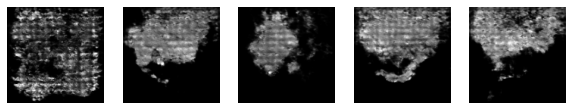

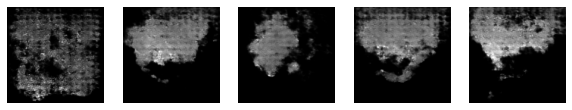

Epoch: 100/1000 | Loss: 0.1405: 100%|██████████| 63/63 [00:37<00:00,  1.69it/s]
Epoch: 101/1000 | Loss: 0.1401: 100%|██████████| 63/63 [00:08<00:00,  7.81it/s]
Epoch: 102/1000 | Loss: 0.1333: 100%|██████████| 63/63 [00:08<00:00,  7.77it/s]
Epoch: 103/1000 | Loss: 0.1296: 100%|██████████| 63/63 [00:07<00:00,  7.89it/s]
Epoch: 104/1000 | Loss: 0.1202: 100%|██████████| 63/63 [00:07<00:00,  8.11it/s]
Epoch: 105/1000 | Loss: 0.1251: 100%|██████████| 63/63 [00:07<00:00,  7.88it/s]
Epoch: 106/1000 | Loss: 0.1297: 100%|██████████| 63/63 [00:07<00:00,  7.89it/s]
Epoch: 107/1000 | Loss: 0.1392: 100%|██████████| 63/63 [00:07<00:00,  7.91it/s]
Epoch: 108/1000 | Loss: 0.1245: 100%|██████████| 63/63 [00:07<00:00,  7.89it/s]
Epoch: 109/1000 | Loss: 0.1354: 100%|██████████| 63/63 [00:08<00:00,  7.83it/s]
Epoch: 110/1000 | Loss: 0.1283: 100%|██████████| 63/63 [00:08<00:00,  7.76it/s]
Epoch: 111/1000 | Loss: 0.1369: 100%|██████████| 63/63 [00:08<00:00,  7.62it/s]
Epoch: 112/1000 | Loss: 0.1292: 100%|███

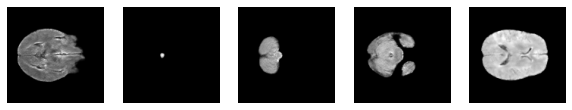

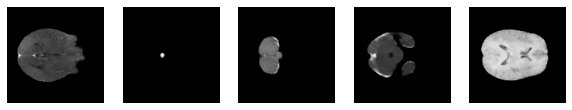

Epoch: 200/1000 | Loss: 0.1041: 100%|██████████| 63/63 [00:36<00:00,  1.74it/s]
Epoch: 201/1000 | Loss: 0.1185: 100%|██████████| 63/63 [00:08<00:00,  7.85it/s]
Epoch: 202/1000 | Loss: 0.1020: 100%|██████████| 63/63 [00:07<00:00,  7.95it/s]
Epoch: 203/1000 | Loss: 0.1274: 100%|██████████| 63/63 [00:07<00:00,  8.18it/s]
Epoch: 204/1000 | Loss: 0.1230: 100%|██████████| 63/63 [00:08<00:00,  7.87it/s]
Epoch: 205/1000 | Loss: 0.1100: 100%|██████████| 63/63 [00:08<00:00,  7.85it/s]
Epoch: 206/1000 | Loss: 0.1065: 100%|██████████| 63/63 [00:07<00:00,  7.90it/s]
Epoch: 207/1000 | Loss: 0.1221: 100%|██████████| 63/63 [00:08<00:00,  7.61it/s]
Epoch: 208/1000 | Loss: 0.1343: 100%|██████████| 63/63 [00:08<00:00,  7.86it/s]
Epoch: 209/1000 | Loss: 0.1051: 100%|██████████| 63/63 [00:08<00:00,  7.77it/s]
Epoch: 210/1000 | Loss: 0.1120: 100%|██████████| 63/63 [00:08<00:00,  7.83it/s]
Epoch: 211/1000 | Loss: 0.1152: 100%|██████████| 63/63 [00:08<00:00,  7.86it/s]
Epoch: 212/1000 | Loss: 0.1246: 100%|███

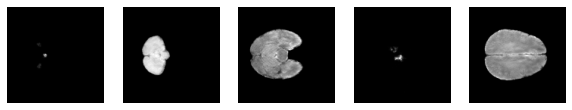

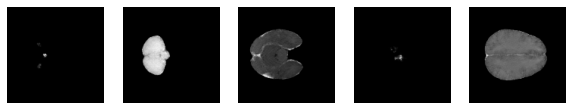

Epoch: 300/1000 | Loss: 0.1129: 100%|██████████| 63/63 [00:36<00:00,  1.72it/s]
Epoch: 301/1000 | Loss: 0.1079: 100%|██████████| 63/63 [00:08<00:00,  7.73it/s]
Epoch: 302/1000 | Loss: 0.0966: 100%|██████████| 63/63 [00:08<00:00,  7.71it/s]
Epoch: 303/1000 | Loss: 0.1095: 100%|██████████| 63/63 [00:08<00:00,  7.85it/s]
Epoch: 304/1000 | Loss: 0.0981: 100%|██████████| 63/63 [00:07<00:00,  7.88it/s]
Epoch: 305/1000 | Loss: 0.0953: 100%|██████████| 63/63 [00:07<00:00,  7.92it/s]
Epoch: 306/1000 | Loss: 0.0883: 100%|██████████| 63/63 [00:07<00:00,  7.99it/s]
Epoch: 307/1000 | Loss: 0.1138:  54%|█████▍    | 34/63 [00:04<00:03,  8.98it/s]

KeyboardInterrupt: 

In [115]:
from models.unet import ResUNet
from models.diffusion import DiffusionModule

AMP = True
accumulation_steps = 1
torch.backends.cudnn.benchmark = True

model = ResUNet(in_channels=latents.shape[1], out_channels=latents.shape[1], T=T).to(device)
# model = torch.compile(model)

print('Model size: {:.2f} mo'.format((sum([p.numel() for p in model.parameters() if p.requires_grad]) * 4) / 1024 ** 2))

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.9))

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=train_loader.__len__() * EPOCHS, eta_min=1e-9, last_epoch=-1
)

scaler = torch.cuda.amp.GradScaler(enabled=AMP)
diffusion = DiffusionModule(T=T, beta_schedule='cosine')
total_loss_history = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    accumulated_loss = []

    progress = tqdm(train_loader, position=0, leave=True)
    for idx, z_q in enumerate(train_loader):
        B = z_q.shape[0]
        z_q = z_q.to(device, dtype=torch.float32, non_blocking=True)

        # sample at random timesteps
        times = torch.randint(low=0, high=T, size=(B,), dtype=torch.long, device=device)

        with torch.autocast(device.type, enabled=AMP):
            # sample noisy images
            x_t, noise = diffusion.forward_process(z_q, times)
            x_t = x_t.to(device, dtype=torch.float32)

            # forward pass
            x_t_pred = diffusion.reverse_process(model, x_t, times)
            loss = F.mse_loss(x_t_pred, noise)


        scaler.scale(loss).backward()
        if (idx + 1) % accumulation_steps == 0 or (idx + 1) == len(train_loader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

            accumulated_loss.append(loss.item())

            with torch.no_grad():
                progress.update(accumulation_steps)
                progress.set_description(f"Epoch: {epoch + 1}/{EPOCHS} | Loss: {np.mean(accumulated_loss):.4f}")

    total_loss_history.append(np.mean(accumulated_loss))

    n_sample = 5
    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            g = diffusion.sample(model=model, x_T=torch.randn(n_sample, 3, 128, 128).to(device))
            g = g.view(n_sample, -1, EMBED_DIM, 16, 16)
            random_idx = torch.randint(low=0, high=g.shape[1], size=(n_sample,), dtype=torch.long, device=device)
            g = g[torch.arange(n_sample), random_idx]
            reconstructed = torch.tanh(ae.decode(g))

        for c in range(IN_CHANNELS):
            plt.figure(figsize=(10, 2))
            for i in range(n_sample):
                plt.subplot(1, n_sample, i + 1)
                plt.imshow(reconstructed[i, c].cpu().numpy(), cmap='gray')
                plt.axis('off')
            plt.show()


In [134]:
# sampling a 3D model and displaying it using IpyWidgets
from ipywidgets import interact

model.eval()
ae.eval()
with torch.no_grad():
    g = diffusion.sample(model=model, x_T=torch.randn(1, 3, 128, 128).to(device))
    g = g.view(-1, EMBED_DIM, 16, 16)
    reconstructed = torch.tanh(ae.decode(g))

def plot_slice(idx, modality):
    m = 0 if modality == 'flair' else 1
    plt.figure(figsize=(5, 5))
    plt.imshow(reconstructed[idx, m].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

interact(plot_slice, idx=(0, reconstructed.shape[0] - 1), modality=['flair', 't1ce'])


Sampling: 100%|██████████| 1000/1000 [00:17<00:00, 56.13it/s]


interactive(children=(IntSlider(value=31, description='idx', max=63), Dropdown(description='modality', options…

<function __main__.plot_slice(idx, modality)>